In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint
from keras import regularizers
import matplotlib.pyplot as plt
from numpy.random import seed
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
%matplotlib inline
# PyOD
from tensorflow.keras import backend as k
from pyod.utils.data import generate_data
from pyod.models.auto_encoder import AutoEncoder
from keras.utils import plot_model
from pyod.utils.utility import standardizer
from pyod.models.combination import aom, moa, average, maximization

from keras.utils.vis_utils import model_to_dot 
from IPython.display import SVG
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from sklearn.mixture import GaussianMixture

C:\Users\A\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [33]:
data = pd.read_csv('dataset.csv')

In [1]:
import pyltp

ModuleNotFoundError: No module named 'pyltp'

In [35]:
# data['date'] = pd.to_datetime(data['Time'])
# data['hour'] = data['date'].dt.hour
# data['day_of_week'] = data['date'].dt.dayofweek
# data['month'] = data['date'].dt.month
# data['year'] = data['date'].dt.year
data.loc[data['WindNumber'].isin([1,2,3,4,6,7,8,9,10]),'radius'] = 99/2
data.loc[data['WindNumber'].isin([1,2,3,4,6,7,8,9,10]),'floorRotor'] = 8.33
data.loc[data['WindNumber'].isin([1,2,3,4,6,7,8,9,10]),'ceilRotor'] = 16.8
data.loc[data['WindNumber'].isin([1,2,3,4,6,7,8,9,10]),'inSpeed'] = 3
data.loc[data['WindNumber'].isin([1,2,3,4,6,7,8,9,10]),'outSpeed'] = 25
data.loc[data['WindNumber']==5,'radius'] = 100.5/2
data.loc[data['WindNumber']==5,'floorRotor'] = 5.5
data.loc[data['WindNumber']==5,'ceilRotor'] = 19
data.loc[data['WindNumber']==5,'inSpeed'] = 3
data.loc[data['WindNumber']==5,'outSpeed'] = 22
data.loc[data['WindNumber']==11,'radius'] = 115/2
data.loc[data['WindNumber']==11,'floorRotor'] = 5
data.loc[data['WindNumber']==11,'ceilRotor'] = 14
data.loc[data['WindNumber']==11,'inSpeed'] = 2.5
data.loc[data['WindNumber']==11,'outSpeed'] = 19
data.loc[data['WindNumber']==12,'radius'] = 104.8/2
data.loc[data['WindNumber']==12,'floorRotor'] = 5.5
data.loc[data['WindNumber']==12,'ceilRotor'] = 17
data.loc[data['WindNumber']==12,'inSpeed'] = 3
data.loc[data['WindNumber']==12,'outSpeed'] = 22
data['para1'] = data['RotorSpeed']*data['radius']/(60*data['WindSpeed'])
data['para1'].fillna(0,inplace=True)
data['para2']=data['Power']/(data['radius']**2*data['WindSpeed']**3)
data['para2'].fillna(0,inplace=True)
data.loc[data['para1']==np.inf,'para1'] = 0
data.loc[data['para1']<-1000,'para1'] = 0
data.loc[data['para2']==np.inf,'para2'] = 0
data.loc[data['para2']==-np.inf,'para2'] = 0
minmax_scaler = MinMaxScaler(feature_range=(0, 1))
std_scaler = StandardScaler()
data['ScaleWindSpeed']=None
data['ScalePower']=None
data['ScaleRotorSpeed']=None
data['ScalePara1']=None
data['ScalePara2']=None
data[['ScaleWindSpeed','ScalePower','ScaleRotorSpeed','ScalePara1','ScalePara2']] = minmax_scaler.fit_transform(data[['WindSpeed','Power','RotorSpeed','para1','para2']])


In [5]:
# data['alpha'] = data['Power']/(0.5*np.pi*np.power(data['radius'],2)*np.power(data['WindSpeed'],3))
# data.loc[data['alpha']==np.inf,'alpha']=0
# data['beta'] = abs(data['Power'] - data['alpha'])  
# data['power_to_rospeed'] = data['Power']/data['RotorSpeed']
# data.loc[data['power_to_rospeed']==np.inf,'power_to_rospeed']=0
# data.loc[(data['lineSpeed']>=0.4)&(data['lineSpeed']<=0.45),'label'] = 0

In [36]:
data['label'] = np.nan
data.head()

,index,WindNumber,Time,WindSpeed,Power,RotorSpeed,radius,floorRotor,ceilRotor,inSpeed,outSpeed,para1,para2,ScaleWindSpeed,ScalePower,ScaleRotorSpeed,ScalePara1,ScalePara2,label
0,0,1,2017/11/1 0:20,4.188333,65.750000,5.779167,49.5,8.33,16.8,3.0,25.0,1.138356,0.000365,0.419569,0.076748,0.178834,0.410852,2.075043e-46,NaN
1,1,1,2017/11/1 0:30,4.042500,120.700000,8.636500,49.5,8.33,16.8,3.0,25.0,1.762551,0.000746,0.415905,0.100808,0.259131,0.432469,2.075043e-46,NaN
2,2,1,2017/11/1 0:40,4.137368,135.157895,8.668421,49.5,8.33,16.8,3.0,25.0,1.728501,0.000779,0.418289,0.107138,0.260028,0.431290,2.075043e-46,NaN
3,3,1,2017/11/1 0:50,4.274737,157.315789,8.727895,49.5,8.33,16.8,3.0,25.0,1.684434,0.000822,0.421740,0.116839,0.261700,0.429764,2.075043e-46,NaN
4,4,1,2017/11/1 1:00,4.108947,129.894737,8.656842,49.5,8.33,16.8,3.0,25.0,1.738132,0.000764,0.417575,0.104833,0.259703,0.431624,2.075043e-46,NaN


In [37]:
#data_test = data.loc[(data['WindSpeed']>data['inSpeed'])&(data['WindSpeed']<data['outSpeed'])]
#data_test = data_test.loc[(data['RotorSpeed']>data['floorRotor'])&(data['RotorSpeed']<data['ceilRotor'])]
data_test = data.loc[(data['Power']>0)&(data['WindSpeed']>0)&(data['RotorSpeed']>0)]

data['label'] = np.where((data['Power']<0)|(data['WindSpeed']<0)|(data['RotorSpeed']<0),1,0)
data['neg_percent'] = data.groupby(['WindNumber'])['label'].transform('mean')
data['target_outlier'] = 0.388 - data['neg_percent']


In [38]:
data.loc[(data['Power']<0)|(data['WindSpeed']<0)|(data['RotorSpeed']<0),'label'].mean()

1.0

In [329]:
len(data.loc[(data['Power']<0)|(data['WindSpeed']<0)|(data['RotorSpeed']<0)])

104592

In [136]:
print(data_test.loc[(data_test['RotorSpeed']>data_test['floorRotor'])].shape)
print(data_test.loc[(data_test['WindSpeed']<data_test['inSpeed'])].shape)

(325674, 19)
(7789, 19)


OUTLIERS :  16690 INLIERS :  24037 K Nearest Neighbors (KNN)


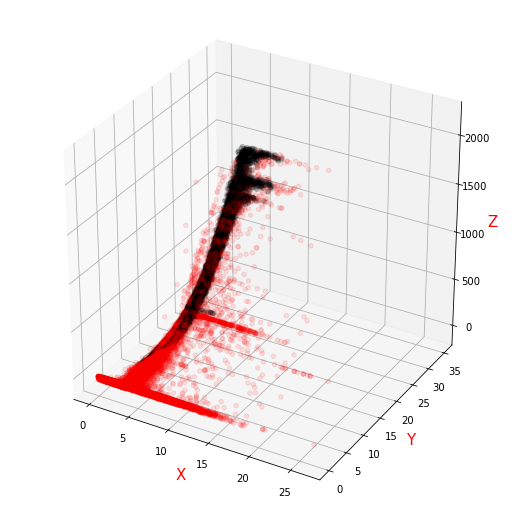

OUTLIERS :  15636 INLIERS :  23219 K Nearest Neighbors (KNN)


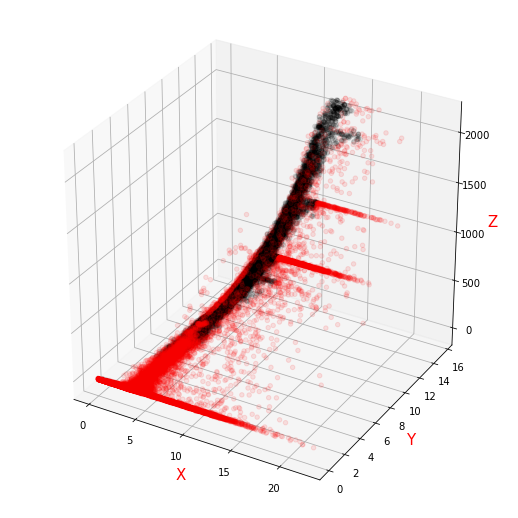

OUTLIERS :  26023 INLIERS :  12972 K Nearest Neighbors (KNN)


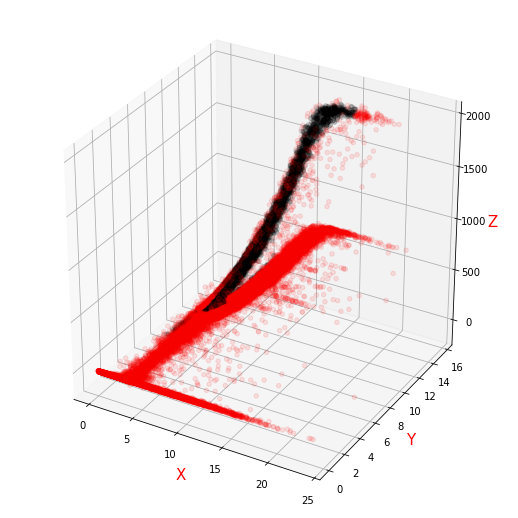

OUTLIERS :  15877 INLIERS :  28458 K Nearest Neighbors (KNN)


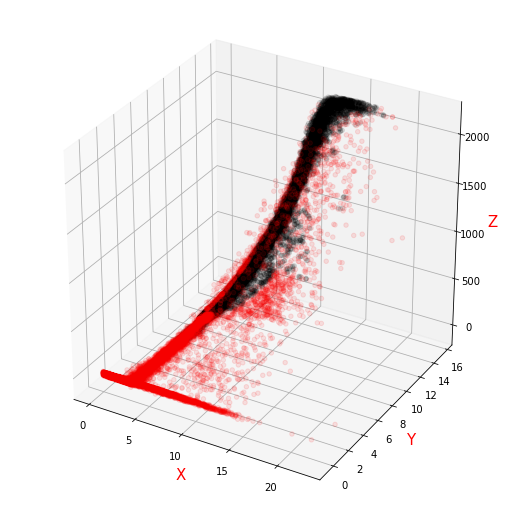

OUTLIERS :  23492 INLIERS :  27470 K Nearest Neighbors (KNN)


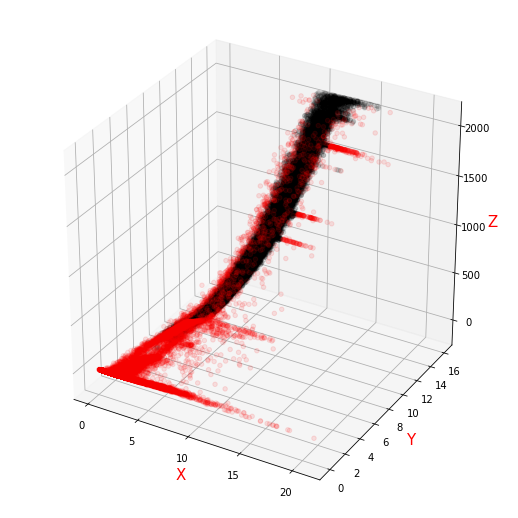

OUTLIERS :  21789 INLIERS :  23803 K Nearest Neighbors (KNN)


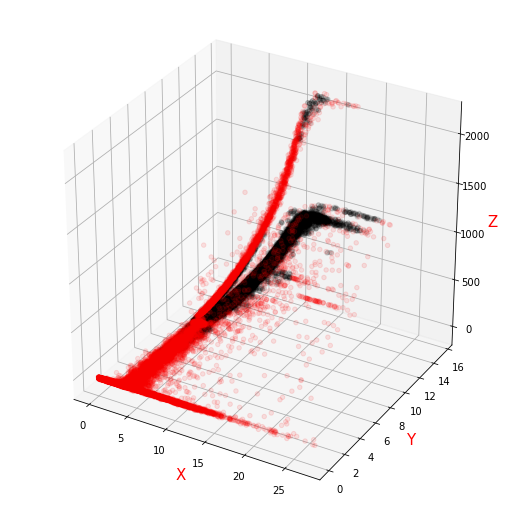

OUTLIERS :  17366 INLIERS :  25958 K Nearest Neighbors (KNN)


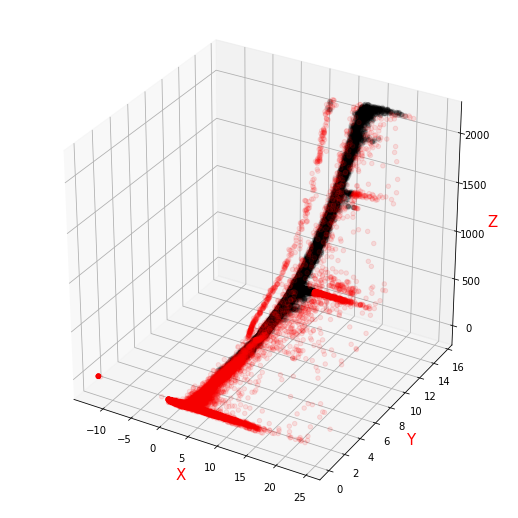

OUTLIERS :  12889 INLIERS :  25581 K Nearest Neighbors (KNN)


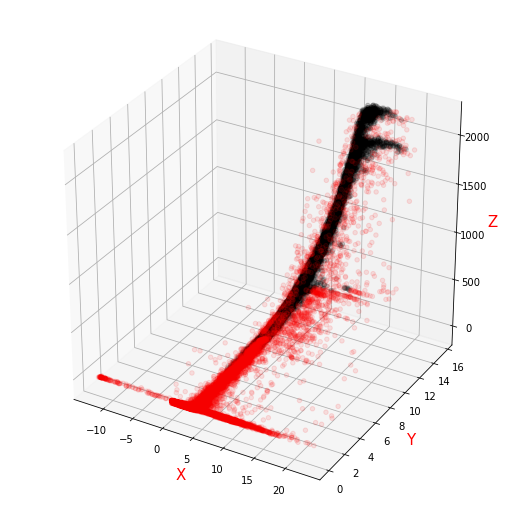

OUTLIERS :  14068 INLIERS :  28756 K Nearest Neighbors (KNN)


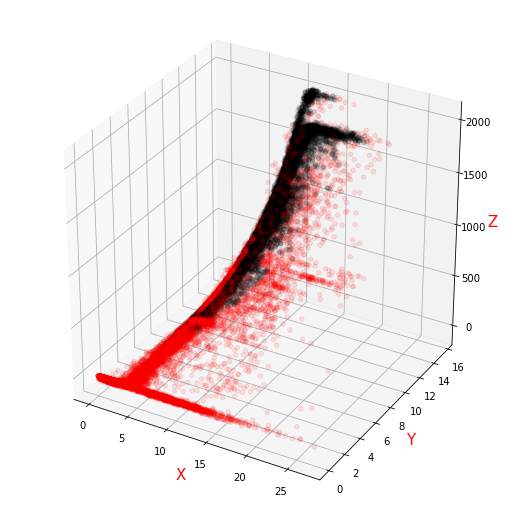

OUTLIERS :  5157 INLIERS :  25027 K Nearest Neighbors (KNN)


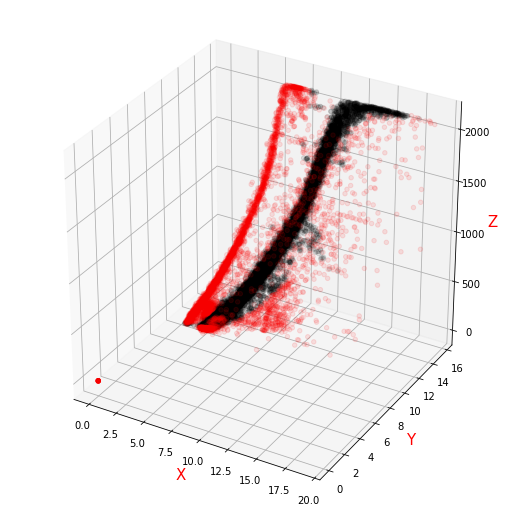

OUTLIERS :  7003 INLIERS :  29845 K Nearest Neighbors (KNN)


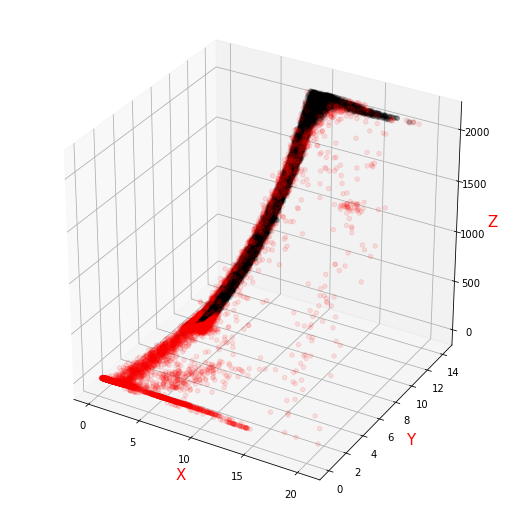

OUTLIERS :  27598 INLIERS :  19123 K Nearest Neighbors (KNN)


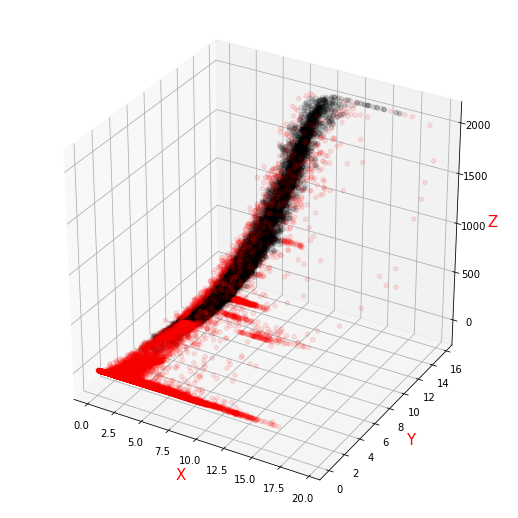

In [113]:
outliers_fraction = 0.05
random_state = np.random.RandomState(42)
classifiers = {
#          'Angle-based Outlier Detector (ABOD)': ABOD(contamination=outliers_fraction)
#           'Cluster-based Local Outlier Factor (CBLOF)':CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state)
#          'Feature Bagging':FeatureBagging(LOF(n_neighbors=10),contamination=outliers_fraction,check_estimator=False,random_state=random_state),
#          'Histogram-base Outlier Detection (HBOS)': HBOS(contamination=outliers_fraction)
#          'Isolation Forest': IForest(contamination=outliers_fraction,random_state=random_state),
            'K Nearest Neighbors (KNN)': KNN(contamination=outliers_fraction,method='mean'),
#         'Average KNN': KNN(method='mean',contamination=outliers_fraction)
}

data_test = data.loc[data['label']==0]
for i in range(1,13):
    X = data_test.loc[(data_test['WindNumber']==i),:]

    for j, (clf_name, clf) in enumerate(classifiers.items()):
        
        clf.fit(X[['ScaleWindSpeed','ScalePower','ScaleRotorSpeed']])
        y_pred = clf.predict(X[['ScaleWindSpeed','ScalePower','ScaleRotorSpeed']])
        data.loc[X.index,'label'] = y_pred
        
#         X1 = X.loc[X['RotorSpeed']<X['floorRotor']]
#         clf.fit(X1[['ScaleWindSpeed','ScalePower','ScaleRotorSpeed',]])
#         y_pred = clf.predict(X1[['ScaleWindSpeed','ScalePower','ScaleRotorSpeed']])
#         data.loc[X1.index,'label'] = y_pred
        
#         X2 = X.loc[X['WindSpeed']>=X['inSpeed']]
#         clf.fit(X2[['ScaleWindSpeed','ScalePower','ScaleRotorSpeed']])
#         y_pred = clf.predict(X2[['ScaleWindSpeed','ScalePower','ScaleRotorSpeed']])
#         data.loc[X2.index,'label'] = y_pred

        
        x_normal =  data.loc[(data['WindNumber']==i)&(data['label']==0),'WindSpeed']
        y_normal =  data.loc[(data['WindNumber']==i)&(data['label']==0),'RotorSpeed']
        z_normal =  data.loc[(data['WindNumber']==i)&(data['label']==0),'Power']

        x_outlier =  data.loc[(data['WindNumber']==i)&(data['label']==1),'WindSpeed']
        y_outlier =  data.loc[(data['WindNumber']==i)&(data['label']==1),'RotorSpeed']
        z_outlier =  data.loc[(data['WindNumber']==i)&(data['label']==1),'Power']

        print('OUTLIERS : ',data.loc[(data['WindNumber']==i)&(data['label']==1)].shape[0],'INLIERS : '
              ,data.loc[(data['WindNumber']==i)&(data['label']==0)].shape[0], clf_name)


        fig = plt.figure(figsize=(7,7))
        sns.scatterplot(z_normal,y_normal)
        ax = Axes3D(fig)
        ax.scatter(x_normal, y_normal, z_normal,color='black',alpha=0.1)
        ax.scatter(x_outlier, y_outlier, z_outlier,color='red',alpha=0.1)

        ax.set_zlabel('Z', fontdict={'size': 15, 'color': 'red'})
        ax.set_ylabel('Y', fontdict={'size': 15, 'color': 'red'})
        ax.set_xlabel('X', fontdict={'size': 15, 'color': 'red'})
        plt.show()
        
#     train_scores_norm = standardizer(train_scores[sub['WindNumber']==i])
#     comb_by_average = average(train_scores_norm)
#     sub.loc[sub['WindNumber']==i,'label'] = comb_by_average

In [116]:
sub = pd.read_csv('submission.csv')

In [136]:
sub.to_csv('sub.csv',index=False)

In [378]:
sub['label'].sum()

200256

In [135]:
sub['label'] = data['label']

In [118]:
sub['label'].mean()

0.4089450964874045

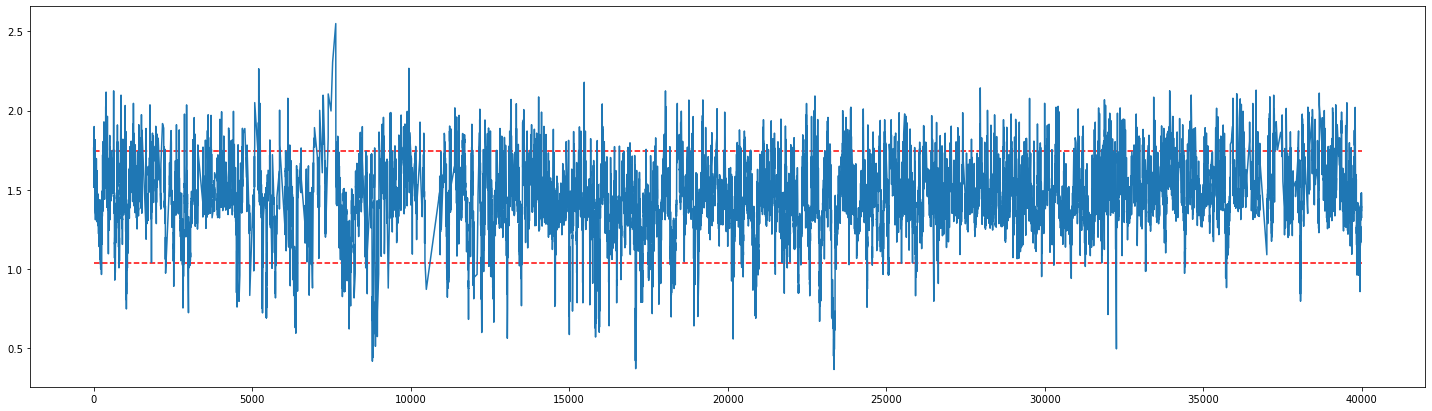

In [88]:
plt.figure(figsize=(25,7))
ind = 40000
data_plot = data.loc[(data['WindNumber']==1)&(data['index']<ind)&
         (data['WindSpeed']>data['inSpeed'])&(data['WindSpeed']<data['outSpeed'])&
         (data['RotorSpeed']>data['floorRotor'])&(data['RotorSpeed']<data['ceilRotor']),'para1']
data_plot.plot()
plt.hlines(data_plot.quantile(0.05), 0, ind, colors = "r", linestyles = "dashed")
plt.hlines(data_plot.quantile(0.95), 0, ind, colors = "r", linestyles = "dashed")

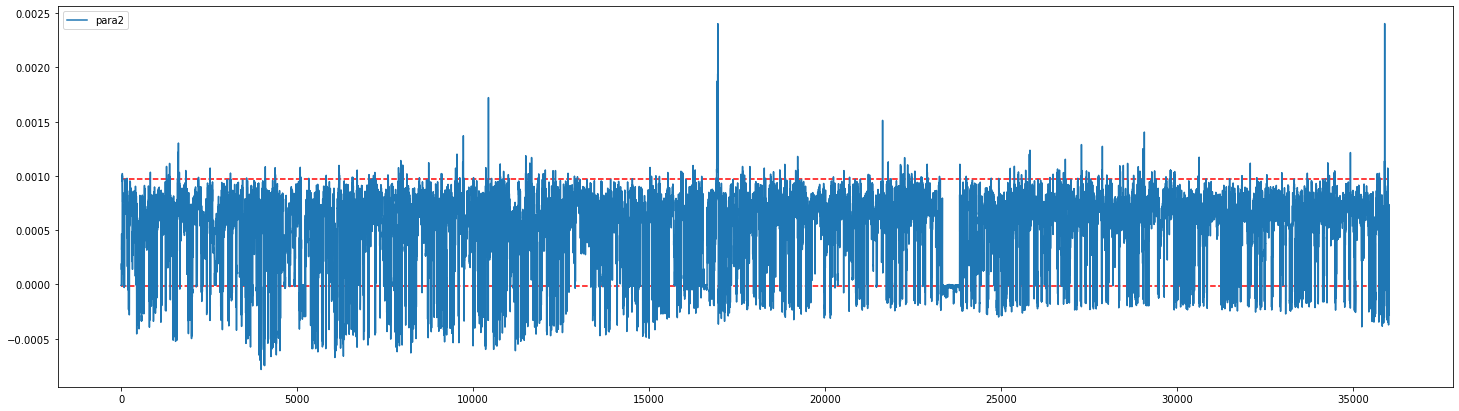

In [208]:

ind = 800000
data_plot = data.loc[(data['WindNumber']==4)&(data['index']<ind)&
         (data['WindSpeed']>data['inSpeed'])&(data['WindSpeed']<data['outSpeed']),'para2']
data_plot.reset_index().drop(['index'],axis=1).plot(figsize=(25,7))
plt.hlines(data_plot.quantile(0.1), 0, len(data_plot), colors = "r", linestyles = "dashed")
plt.hlines(data_plot.quantile(0.99), 0, len(data_plot), colors = "r", linestyles = "dashed")

In [125]:
low_percent = 0.1
high_percent = 0.9
# para1_low = data.loc[(data['WindSpeed']>data['inSpeed'])&(data['WindSpeed']<data['outSpeed'])].groupby(['WindNumber'])['para1'].quantile(0.05)
# para1_high = data.loc[(data['WindSpeed']>data['inSpeed'])&(data['WindSpeed']<data['outSpeed'])].groupby(['WindNumber'])['para1'].quantile(high_percent)
# para2_low = data.loc[(data['WindSpeed']>data['inSpeed'])&(data['WindSpeed']<data['outSpeed'])].groupby(['WindNumber'])['para2'].quantile(low_percent)
# para2_high = data.loc[(data['WindSpeed']>data['inSpeed'])&(data['WindSpeed']<data['outSpeed'])].groupby(['WindNumber'])['para2'].quantile(high_percent)
para1_low = data.loc[(data['WindSpeed']>data['inSpeed'])&(data['WindSpeed']<data['outSpeed'])&
         (data['RotorSpeed']>data['floorRotor'])&(data['RotorSpeed']<data['ceilRotor'])&(data['Power']<2000)].groupby(['WindNumber'])['para1'].quantile(0.05)
para1_high = data.loc[(data['WindSpeed']>data['inSpeed'])&(data['WindSpeed']<data['outSpeed'])&
         (data['RotorSpeed']>data['floorRotor'])&(data['RotorSpeed']<data['ceilRotor'])&(data['Power']<2000)].groupby(['WindNumber'])['para1'].quantile(high_percent)
para2_low = data.loc[(data['WindSpeed']>data['inSpeed'])&(data['WindSpeed']<data['outSpeed'])&
         (data['RotorSpeed']>data['floorRotor'])&(data['RotorSpeed']<data['ceilRotor'])&(data['Power']<2000)].groupby(['WindNumber'])['para2'].quantile(low_percent)
para2_high = data.loc[(data['WindSpeed']>data['inSpeed'])&(data['WindSpeed']<data['outSpeed'])&
         (data['RotorSpeed']>data['floorRotor'])&(data['RotorSpeed']<data['ceilRotor'])&(data['Power']<2000)].groupby(['WindNumber'])['para2'].quantile(high_percent) 

In [126]:
data['para1_low'] = data['WindNumber'].map(para1_low)
data['para1_high'] = data['WindNumber'].map(para1_high)
data['para2_low'] = data['WindNumber'].map(para2_low)
data['para2_high'] = data['WindNumber'].map(para2_high)

In [133]:
data['label'].mean()


0.41095579476816707

In [42]:

data.loc[(data['Power']<2000)&
         ((data['para2']<data['para2_low'])|(data['para2']>data['para2_high'])),'label'] = 1
# data.loc[(data['WindSpeed']>data['inSpeed'])&(data['WindSpeed']<data['outSpeed'])&
#          (data['RotorSpeed']>data['floorRotor'])&(data['RotorSpeed']<data['ceilRotor'])&(data['Power']<1500)&
#          (data['para1']<data['para1_low']),'label'] = 1

In [47]:
data.loc[(data['Power']<500)&
         ((data['para2']<data['para2_low'])),'label'] = 1

In [131]:
# data.loc[(data['Power']>1500)&(data['Power']<1700)&(data['WindNumber']==5)&
#          ((data['para2']<data['para2_low'])),'label'] = 1
# data.loc[(data['Power']>700)&(data['Power']<1000)&(data['WindNumber']==5)&
#          ((data['para2']<data['para2_low'])),'label'] = 1
# data.loc[(data['Power']>1000)&(data['Power']<1100)&(data['WindNumber']==2)&
#          ((data['para2']<data['para2_low'])),'label'] = 1
# data.loc[(data['Power']>500)&(data['Power']<700)&(data['WindNumber']==2)&
#          ((data['para2']<data['para2_low'])),'label'] = 1
# data.loc[(data['Power']>500)&(data['Power']<1000)&(data['WindNumber']==12)&
#          ((data['para2']<data['para2_low'])),'label'] = 1
# data.loc[(data['Power']>500)&(data['Power']<600)&(data['WindNumber']==7)&
#          ((data['para2']<data['para2_low'])),'label'] = 1
# data.loc[(data['Power']>500)&(data['Power']<600)&(data['WindNumber']==9)&
#          ((data['para2']<data['para2_low'])),'label'] = 1
data.loc[(data['Power']>1600)&(data['Power']<1900)&(data['WindNumber']==1)&
         ((data['para2']<data['para2_low'])),'label'] = 1

In [ ]:
data.loc[(data['WindNumber']==3)&(data['Power']<1000)&(data['Power']>100)&
         ((data['para2']<data['para2_low'])),'label'] = 1

In [111]:
# data.loc[(data['WindNumber']==10)&
#          ((data['para2']>data['para2_high'])),'label'] = 1
data.loc[(data['WindNumber']==6)&
         ((data['para2']>data['para2_high'])),'label'] = 1


OUTLIERS :  17316 INLIERS :  23411


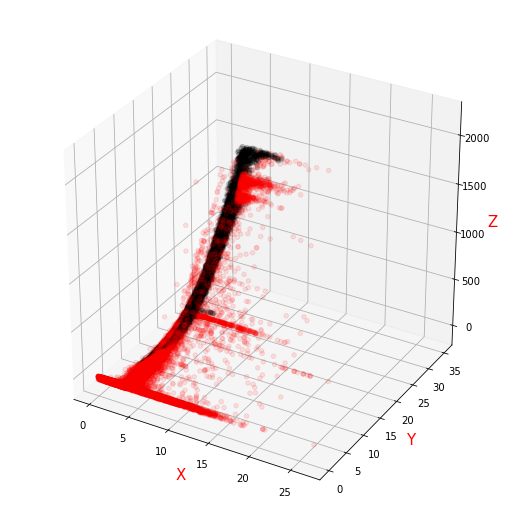

OUTLIERS :  15636 INLIERS :  23219


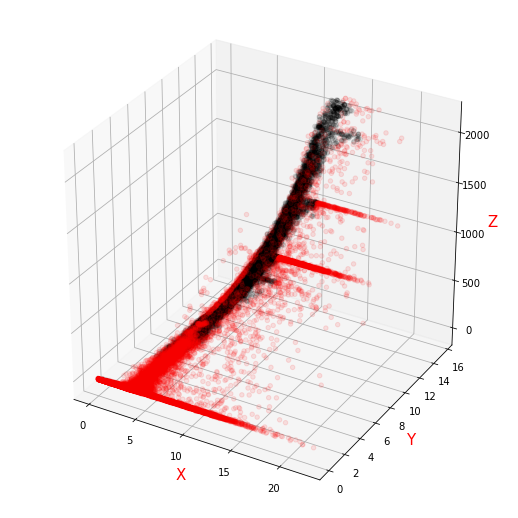

OUTLIERS :  26023 INLIERS :  12972


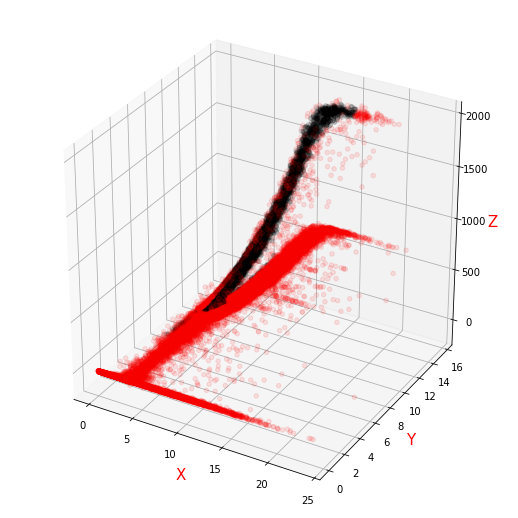

OUTLIERS :  15877 INLIERS :  28458


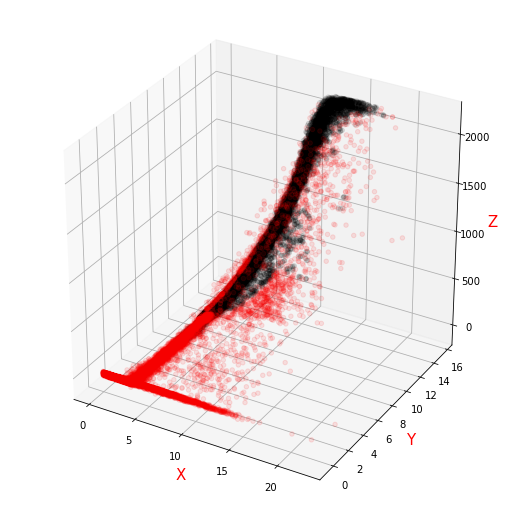

OUTLIERS :  23492 INLIERS :  27470


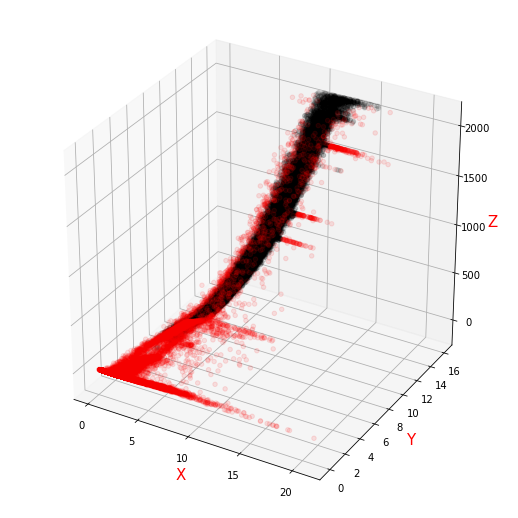

OUTLIERS :  21789 INLIERS :  23803


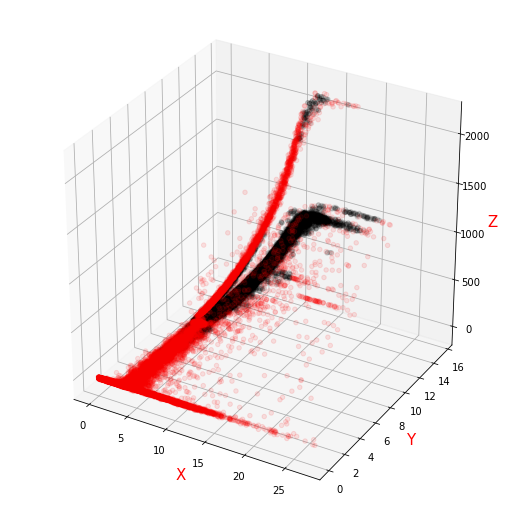

OUTLIERS :  17366 INLIERS :  25958


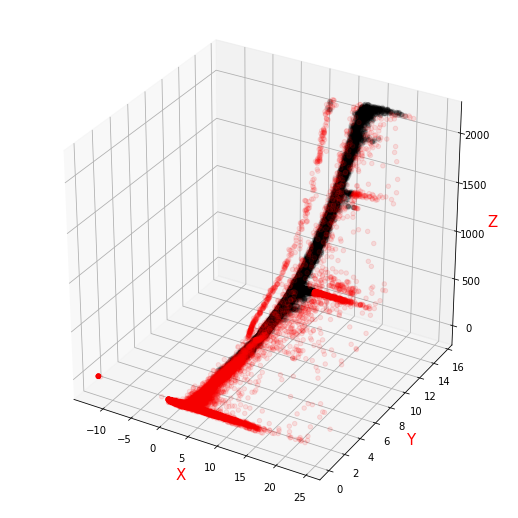

OUTLIERS :  13264 INLIERS :  25206


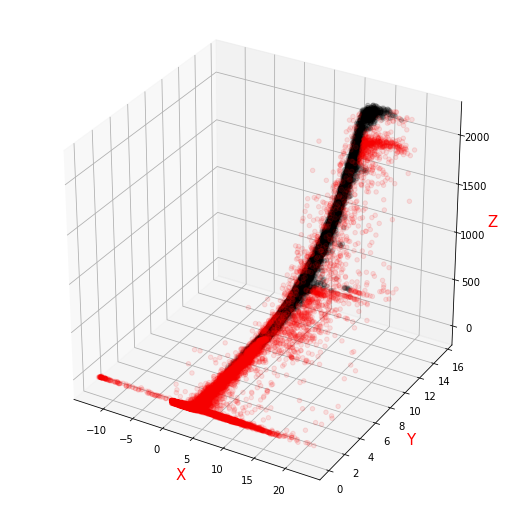

OUTLIERS :  14068 INLIERS :  28756


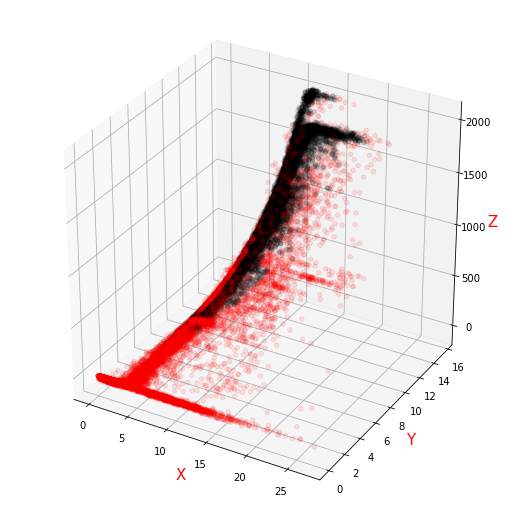

OUTLIERS :  5157 INLIERS :  25027


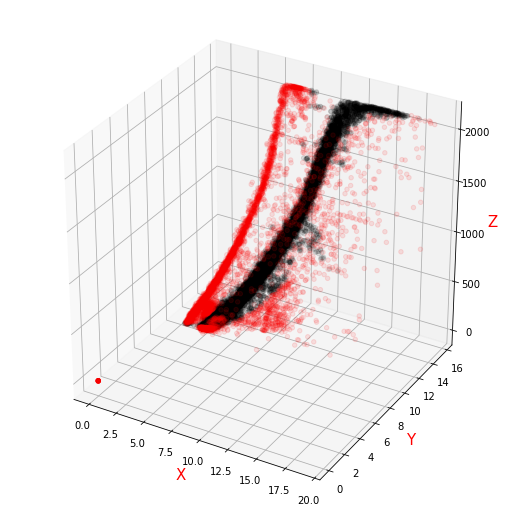

OUTLIERS :  7003 INLIERS :  29845


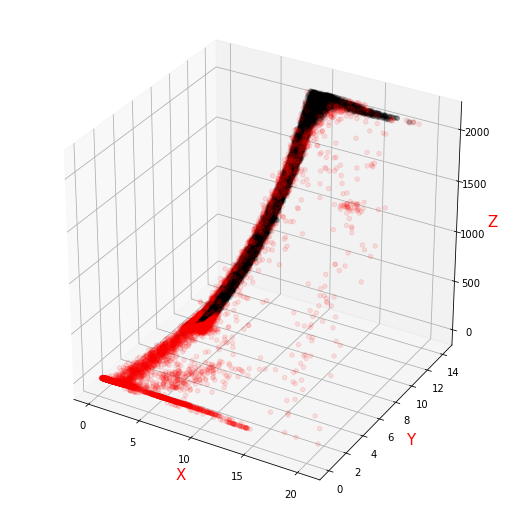

OUTLIERS :  27598 INLIERS :  19123


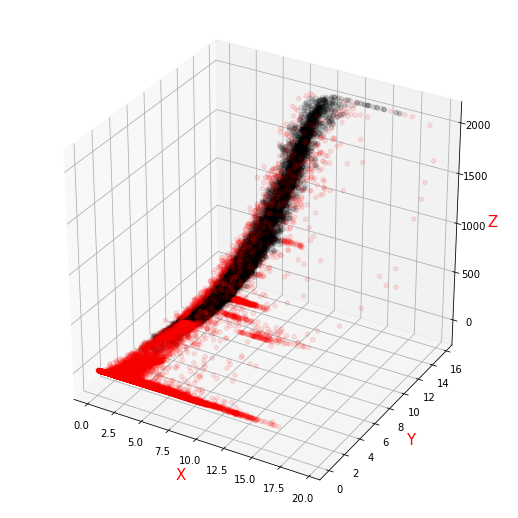

In [132]:
for i in range(1,13):
    X = data.loc[(data['WindNumber']==i),['WindSpeed','Power','RotorSpeed','label']]


    x_normal =  X.loc[X['label']==0]['WindSpeed']
    y_normal =  X.loc[X['label']==0]['RotorSpeed']
    z_normal =  X.loc[X['label']==0]['Power']

    x_outlier =  X.loc[X['label']==1]['WindSpeed']
    y_outlier =  X.loc[X['label']==1]['RotorSpeed']
    z_outlier =  X.loc[X['label']==1]['Power']

    print('OUTLIERS : ',len(X.loc[X['label']==1]),'INLIERS : ',len(X.loc[X['label']==0]))


    fig = plt.figure(figsize=(7,7))
    sns.scatterplot(z_normal,y_normal)
    ax = Axes3D(fig)
    ax.scatter(x_normal, y_normal, z_normal,color='black',alpha=0.1)
    ax.scatter(x_outlier, y_outlier, z_outlier,color='red',alpha=0.1)

    ax.set_zlabel('Z', fontdict={'size': 15, 'color': 'red'})
    ax.set_ylabel('Y', fontdict={'size': 15, 'color': 'red'})
    ax.set_xlabel('X', fontdict={'size': 15, 'color': 'red'})
    plt.show()

In [290]:
data.head()

,index,WindNumber,Time,WindSpeed,Power,RotorSpeed,radius,floorRotor,ceilRotor,inSpeed,...,ScaleRotorSpeed,ScalePara1,ScalePara2,label,neg_percent,target_outlier,para1_low,para1_high,para2_low,para2_high
0,0,1,2017/11/1 0:20,4.188333,65.750000,5.779167,49.5,8.33,16.8,3.0,...,0.178834,0.410852,2.075043e-46,1,0.316964,0.071036,1.039483,1.742269,0.000401,0.000824
1,1,1,2017/11/1 0:30,4.042500,120.700000,8.636500,49.5,8.33,16.8,3.0,...,0.259131,0.432469,2.075043e-46,0,0.316964,0.071036,1.039483,1.742269,0.000401,0.000824
2,2,1,2017/11/1 0:40,4.137368,135.157895,8.668421,49.5,8.33,16.8,3.0,...,0.260028,0.431290,2.075043e-46,0,0.316964,0.071036,1.039483,1.742269,0.000401,0.000824
3,3,1,2017/11/1 0:50,4.274737,157.315789,8.727895,49.5,8.33,16.8,3.0,...,0.261700,0.429764,2.075043e-46,0,0.316964,0.071036,1.039483,1.742269,0.000401,0.000824
4,4,1,2017/11/1 1:00,4.108947,129.894737,8.656842,49.5,8.33,16.8,3.0,...,0.259703,0.431624,2.075043e-46,0,0.316964,0.071036,1.039483,1.742269,0.000401,0.000824


In [388]:
sub = pd.read_csv('submission.csv')
sub['label'] = data['label']
sub.to_csv('sub.csv',index=False)

In [374]:
data['label'].mean()

0.35456183449602985

In [381]:
data.groupby(['WindNumber'])['label'].mean()

WindNumber
1     0.409802
2     0.385690
3     0.668163
4     0.358114
5     0.459951
6     0.448368
7     0.397101
8     0.335040
9     0.324281
10    0.140174
11    0.190051
12    0.589713
Name: label, dtype: float64